# 15wk-2: 기말고사 (ver 1.0)

최규빈  
2025-06-18

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/fin.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
#--# 문제1
import pandas as pd
import sklearn.model_selection
#--# 문제4
import gymnasium as gym
import IPython
from matplotlib.animation import FuncAnimation
import collections
import random

# `1`. `ml-20m`

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-20m.zip
!unzip ml-20m.zip

MovieLens 20M 데이터셋은 GroupLens Research에서 제공하는 영화 평점
데이터셋으로, 영화 추천 시스템 연구에 널리 사용된다. 이 데이터셋은 약
2천만 개의 영화 평점과 메타데이터를 포함하고 있다. 주요 파일과 그 내용은
다음과 같다:

`1`. **ratings.csv**:

-   **userId**: 사용자의 고유 ID
-   **movieId**: 영화의 고유 ID
-   **rating**: 사용자가 부여한 평점 (0.0에서 1.0 사이의 값)
-   **timestamp**: 평점이 부여된 시간 (유닉스 타임스탬프 형식)

`2`. **movies.csv**:

-   **movieId**: 영화의 고유 ID
-   **title**: 영화 제목
-   **genres**: 영화 장르 (여러 개의 장르가 ’\|’로 구분됨)

`3`. **tags.csv**:

-   **userId**: 사용자의 고유 ID
-   **movieId**: 영화의 고유 ID
-   **tag**: 사용자가 부여한 태그
-   **timestamp**: 태그가 부여된 시간 (유닉스 타임스탬프 형식)

`4`. **genome-scores.csv**:

-   **movieId**: 영화의 고유 ID
-   **tagId**: 태그의 고유 ID
-   **relevance**: 해당 태그가 영화에 얼마나 관련 있는지 나타내는 점수
    (0.0에서 1.0 사이의 값)

`5`. **genome-tags.csv**:

-   **tagId**: 태그의 고유 ID
-   **tag**: 태그의 이름

`6`. **links.csv**:

-   **movieId**: 영화의 고유 ID
-   **imdbId**: IMDB에서의 영화 ID
-   **tmdbId**: TMDB에서의 영화 ID

이중에서 1,2의 데이터만 사용하여 추천시스템을 설계하기로 하자.

In [ ]:
np.random.seed(43052)
df_ratings = pd.read_csv("ml-20m/ratings.csv")
df_movies = pd.read_csv("ml-20m/movies.csv")
df_train_all = pd.merge(df_ratings,df_movies)
userId_sampled = np.random.choice(df_train_all.userId.unique(),5000,replace=False); userId_sampled[0] = 46889
df_train = df_train_all.query("userId in @userId_sampled").reset_index(drop=True)
df_train["userId"] = df_train.userId.map({user:i for i,user in enumerate(set(df_train.userId))}) 
df_train["movieId"] = df_train.movieId.map({movie:i for i,movie in enumerate(set(df_train.movieId))}) 

평점정보와 영화정보를 결합하여 `df_train`을 만들었으며, 위의 코드를
간단히 설명하면 아래와 같다.

`1`. `df_ratings`와 `df_movies` CSV 파일을 읽어 데이터프레임으로 만든다.

``` python
df_ratings = pd.read_csv("ml-20m/ratings.csv")
df_movies = pd.read_csv("ml-20m/movies.csv")
```

`2`. 평점 데이터와 영화 데이터를 합쳐 하나의 데이터프레임
`df_train_all`을 만든다.

``` python
df_train_all = pd.merge(df_ratings, df_movies)
```

`3`. 데이터가 너무 많아 5000명의 유저만 랜덤으로 샘플링한다. (이때 유저
`46889`는 반드시 포함)

``` python
userId_sampled = np.random.choice(df_train_all.userId.unique(), 5000, replace=False); userId_sampled[0] = 46889
```

`4`. 샘플링된 5000명의 유저 데이터만 포함하는 새로운 데이터프레임
`df_train`을 만든다.

``` python
df_train = df_train_all.query("userId in @userId_sampled").reset_index(drop=True)
```

`5`. 유저 ID를 0부터 시작하는 인덱스로 재조정한다.

``` python
df_train["userId"] = df_train.userId.map({user: i for i, user in enumerate(set(df_train.userId))})
```

`6`. 영화 ID도 0부터 시작하는 인덱스로 재조정한다.

``` python
df_train["movieId"] = df_train.movieId.map({movie: i for i, movie in enumerate(set(df_train.movieId))})
```

In [3]:
df_train

`(1)` `df_train`을 아래와 같이 `X_train`, `X_val`, `y_train`, `y_val`로
나누고 NN-based 추천시스템을 설계하고 학습하라. 학습결과를 **validation
loss**로 검증하라.

In [4]:
X1 = torch.tensor(df_train.userId)
X2 = torch.tensor(df_train.movieId)
X = torch.stack([X1,X2],axis=1)
y = torch.tensor(df_train.rating).float().reshape(-1,1)

In [5]:
X_train,X_val,y_train,y_val = sklearn.model_selection.train_test_split(X,y,test_size=0.1,random_state=42)

**힌트:** 아래의 코드를 이용하세요..

``` python
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        ????   
    def forward(self,X):
        ???
        return yhat
#---#
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
ds = torch.utils.data.TensorDataset(X_train,y_train)
dl = torch.utils.data.DataLoader(ds,batch_size=8,shuffle=True)
#--# 
for epoc in range(5):
    net.to("cuda:0")
    for xi,yi in dl:
        xi = xi.to("cuda:0")
        yi = yi.to("cuda:0")
        # 1
        yi_hat = net(xi) 
        # 2
        loss = loss_fn(yi_hat,yi)
        # 3 
        loss.backward()
        # 4 
        optimizr.step()
        optimizr.zero_grad()
    net.to("cpu")
    print(f"epoch: {epoc+1}\t val_loss: {loss_fn(net(X_val).data,y_val):.4f}")
```

In [8]:
# 학습결과

epoch: 1     val_loss: 0.7995
epoch: 2     val_loss: 0.7595
epoch: 3     val_loss: 0.7444
epoch: 4     val_loss: 0.7383
epoch: 5     val_loss: 0.7334

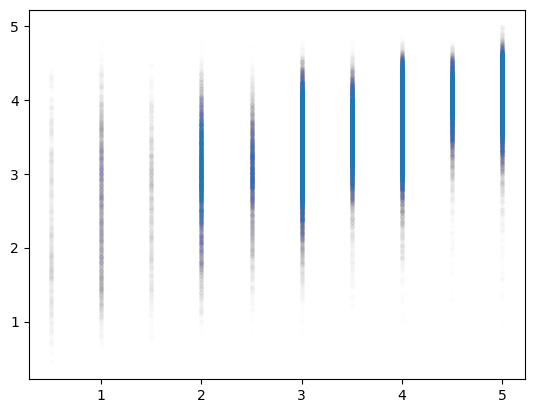

In [9]:
# 시각화 
plt.plot(y_val,net(X_val).data,'.',alpha=0.002)

-   전체적으로 우상향 $\to$ 그럭저럭 잘맞춤

`(2)` 아래는 유저 2303번에 대한 정보이다.

In [10]:
df_train.query("userId == 2303")

유저 2303는 스릴러를 좋아하는 것 같다. 영화 {49:
`Usual Suspects, The (1995)`} 는 스리럴중에서도 인기가 있는 영화인데,
유저 2303는 아직 이 영화를 시청하지 않은듯 보인다.

In [11]:
df_train.query("'Usual Suspects, The (1995)' in title")

유저 2303에게 이 영화를 추천하면 어떠한 평점을 줄까? (1)에서 학습한
네트워크로 예측하여 보라.

# 2. `hello`

아래와 같이 hello가 반복되는 자료가 있다고 하자.

In [229]:
txt = list('hello')*100
txt[:10]

`(1)` `torch.nn.RNN()`을 이용하여 다음문자를 예측하는 신경망을 설계하고
학습하라.

`(2)` `torch.nn.RNNCell()`을 이용하여 다음문자를 예측하는 신경망을
설계하고 학습하라.

`(3)` `(2)`의 결과와 동일한 적합값을 출력하는 신경망을 직접설계한뒤
학습시켜라. (초기값을 적절하게 설정할 것)

``` python
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = ????
        self.h2h = ????
        self.tanh = ????
    def forward(self,??,??):
        ht = ????
        return ht
```

위의 클래스의 `????`를 체워 (2)의 결과와 동일한 적합값이 나오도록 하라.

-   class를 이용하지 않으면 점수없음.
-   `torch.nn.RNN()`, `torch.nn.RNNCell()` 을 이용한 네트워크를
    학습시킬시 점수 없음. (초기값을 셋팅하는 용도로는 torch.nn.RNN(),
    torch.nn.RNNCell()을 코드에 포함시키는 것이 가능)

# 3. `Human_Numbers`

`HUMAN_NUMBERS_train.txt` 사람이 읽을 수 있는 형식으로 숫자가 나열된
텍스트 파일이다. 이 텍스트 파일을 이용하여 “현재 단어가 주어졌을 때 다음
단어를 예측하는” 신경망을 설계하고 학습시킬 것이다. 아래는 해당 파일을
불러와 단어 단위로 나눈 결과를 확인하는 코드이다.

In [1]:
!wget https://raw.githubusercontent.com/guebin/DL2025/main/posts/HUMAN_NUMBERS_train.txt
with open('HUMAN_NUMBERS_train.txt') as f:
    words = f.read().split()
!rm HUMAN_NUMBERS_train.txt

--2025-06-16 22:46:40--  https://raw.githubusercontent.com/guebin/DL2025/main/posts/HUMAN_NUMBERS_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 280599 (274K) [text/plain]
Saving to: ‘HUMAN_NUMBERS_train.txt’

HUMAN_NUMBERS_train 100%[===================>] 274.02K  --.-KB/s    in 0.01s   

2025-06-16 22:46:40 (18.8 MB/s) - ‘HUMAN_NUMBERS_train.txt’ saved [280599/280599]


In [2]:
print(words[-12:])

['seven', 'thousand', 'nine', 'hundred', 'ninety', 'eight', 'seven', 'thousand', 'nine', 'hundred', 'ninety', 'nine']

이 텍스트 파일에는 예를 들어 “… seven, thousand, nine, hundred, ninety,
eight, …” 등과 같은 사람이 읽는 숫자 표현이 단어 단위로 나열된 시퀀스
형태로 저장되어 있다.

이러한 데이터에서 “현재 단어가 주어졌을 때 다음 단어를 예측하는” 자연어
처리 모델을 학습하라. 즉 아래와 같은 맵핑을 학습하라. (꼭 다맞출 필요는
없습니다)

-   … seven, thousand, nine, hundred, ninety, eight $\to$ seven
-   … seven, thousand, nine, hundred, ninety, eight, seven $\to$
    thousand
-   … seven, thousand, nine, hundred, ninety, eight, seven, thousand
    $\to$ nine

**제약사항**

-   one-hot 전처리 코드를 포함할 것
-   `torch.nn.RNN`, `torch.nn.RNNCell`, `torch.nn.LSTM` 중 하나를 이용할
    것
-   처음 12개의 단어와 마지막 12개의 단어에 대한 적합값(fitted value)을
    제시할 것

**hint**: 아래의 코드를 이용하여 전처리하면 편리하다.

In [42]:
df_train = pd.DataFrame({'x': words[:-1], 'y': words[1:]})
df_train

In [41]:
# 전체 vocab 기준으로 맵핑
vocab = sorted(set(words))
dct= {w: i for i, w in enumerate(vocab)}
# train 데이터셋
x = torch.tensor(df_train.x.map(dct))
y = torch.tensor(df_train.y.map(dct))

# 4. `FrozenLake`

ref: <https://gymnasium.farama.org/environments/toy_text/frozen_lake/>

아래는 OpenAI Gym 라이브러리에서 제공하는 환경 Frozen Lake를 구체화하여
변수 `env`에 저장하는 코드이다.

In [8]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode='rgb_array')

Frozen Lake 환경은 강화학습(RL) 실험을 위한 간단한 시뮬레이션 환경으로
에이전트가 얼어붙은 호수 위를 안전하게 건너 목표 지점에 도달하는 것이
목표이다. 주요 특징은 다음과 같다.

`1`. **환경 구성**:

-   격자형(grid) 환경으로 이루어져 있으며, 각 격자는 4x4 또는 8x8의
    형태를 가질 수 있다. (문제에서는 4x4)
-   격자는 시작 지점(Start), 목표 지점(Goal), 얼음(Ice), 그리고
    구멍(Hole)으로 구성된다.
-   에이전트는 시작 지점에서 목표 지점까지 이동해야 한다.

`2`. **에이전트의 동작**:

-   에이전트는 상, 하, 좌, 우로 이동할 수 있다.
-   얼음 위에서는 자유롭게 이동할 수 있지만, 구멍에 빠지면 에피소드가
    종료된다.

`3`. **보상 체계**:

-   에이전트가 목표 지점에 도달하면 +1의 보상을 받는다.
-   그 외에는 보상이 없다(0 보상).
-   구멍에 빠지거나 목표 지점에 도달하지 못하면 보상은 없다.

`4`. **목표**:

-   에이전트는 강화학습 알고리즘을 사용하여 최적의 경로를 학습하고,
    가능한 한 구멍에 빠지지 않고 목표 지점에 도달하는 것이다.

아래는 `show` 함수이며, 이는 `env`의 현재상태를 렌더링해주는 역할을
한다.

In [119]:
def show(imgs):
    fig = plt.Figure()
    ax = fig.subplots()
    def update(i):
        ax.imshow(imgs[i])
    ani = FuncAnimation(fig,update,frames=len(imgs))
    display(IPython.display.HTML(ani.to_jshtml()))

`show()` 함수의 사용방법은 아래와 같다.

In [122]:
imgs = [] 
env.reset()
while True:
    img = env.render()
    imgs.append(img)
    #---#
    player.act()
    player.next_state, player.reward, player.terminated, player.truncated, _ = env.step(player.action)
    if player.terminated or player.truncated:
        break
    else:
        player.state = player.next_state
show(imgs)        

적당한 위의 환경에 대응하는 Agent를 설계하고 `q_net`를 이용하여 올바른
행동을 학습하라. (최근 100번의 평균점수가 0.9 이상이면 만점으로 인정)

**힌트1:** 아래의 에이전트를 설계에 활용하세요

In [123]:
class RandomAgent: 
    def __init__(self):
        #--# define spaces 
        self.action_space = gym.spaces.Discrete(4)
        #--# replay buffer 
        self.state =  None   
        self.action = None           
        self.reward = None           
        self.next_state = None      
        self.terminated = None
        self.truncated = None 
        #-#
        self.states = collections.deque(maxlen=5000)
        self.actions = collections.deque(maxlen=5000)
        self.rewards = collections.deque(maxlen=5000)
        self.next_states = collections.deque(maxlen=5000)
        self.terminations = collections.deque(maxlen=5000)
        #--# other information 
        self.n_experiences = 0
        self.eps = 1.0
    def act(self):
        self.action = self.action_space.sample()
    def learn(self):
        pass 
    def save_experience(self):
        self.states.append(torch.tensor(self.state))
        self.actions.append(self.action)
        self.rewards.append(self.reward)
        self.next_states.append(torch.tensor(self.next_state))
        self.terminations.append(self.terminated)
        #--#
        self.n_experiences = self.n_experiences + 1 

**힌트2**: `q_net`의 첫 레이어는 `torch.nn.Embedding()`을 이용하세요

-   상태공간(state space)이 0~15일텐데, `상태1 x 2 = 상태2`,
    `상태3 + 상태2 = 상태5` 와 같은 관계가 성립한다고 보기 어려우므로
    상태공간은 범주형변수로 봐야겠죠?

**힌트3**: 학습이 잘 되지 않는다면 아래를 체크해보세요.

-   `q_net(s)`가 올바른 값을 주는지 확인합시다.
    -   예를들어 q_net(s)의 값은 0~1사이에 있어야 하겠구요,
    -   상태14에서는 오른쪽(action=2)으로 가야합니다. (액션값과 상태에
        대한 정의값은 공식문서를 참고하세요)
-   네크워크를 엄청 복잡하게 할 필요는 없습니다. (저는 레이어3장썼고요..
    레이어에서 최대 노드수는 32를 넘지 않아요)
-   그외 제가 학습에 사용한 여러 설정을 공유합니다. (아마 꼭 저대로
    안해도 될걸요?)
    -   GPU 사용 X
    -   학습시간: 5분쯤?
    -   옵티마이저: 아담
    -   학습률: 디폴트
    -   배치사이즈: 128
    -   랜덤액션 확률: 매 에피소드마다 “이전 확률 × 0.995” 방식으로 점차
        감소

In [130]:
#

에피소드: 100    경험: 818     점수: 0.12    게임시간: 7.18  돌발행동: 0.61 
에피소드: 200    경험: 1538    점수: 0.37    게임시간: 6.20  돌발행동: 0.37 
에피소드: 300    경험: 2350    점수: 0.72    게임시간: 7.12  돌발행동: 0.22 
에피소드: 400    경험: 3013    점수: 0.78    게임시간: 5.63  돌발행동: 0.13 
에피소드: 500    경험: 3648    점수: 0.89    게임시간: 5.35  돌발행동: 0.08 
--에피소드 542에서 클리어--

# 5. `4x4 GirdWorld`

아래의 제약조건에 맞추어 14wk-2의 Solve를 해결할 것

1.  **Q-테이블 초기화 및 사용 방식**: 에이전트는 `q_net`이 아닌
    `q_table`을 사용하여 업데이트하며, `q_table`은 np.random.randn(4, 4,
    4)로 초기화된다.
2.  **액션 선택 전략**: 매 스텝마다 일정 확률로 랜덤 액션을 수행하고,
    랜덤이 아닐 경우에는 q_table을 참고해 가장 높은 Q값을 갖는 최적의
    액션을 선택한다.
3.  **탐험 확률 감소 (ε-greedy)**: 랜덤액션을 선택하는 확률은 초기값
    100%에서 시작하여, 매 에피소드마다 “이전 확률 × 0.995” 방식으로 점차
    감소한다.
4.  **감가율 (Discount Factor)**: 미래 보상의 중요도를 반영하기 위한
    감가율은 0.95로 설정한다.
5.  **학습률 (Learning Rate)**: `q`와 `q_hat`의 차이를 얼마나 반영할지를
    결정하는 학습률은 0.01로 설정한다.
6.  **경험 메모리 구조**: 플레이어(=에이전트)는 최대 5000개의 경험을
    저장할 수 있다.
7.  **학습 조건 및 방식 (learn 함수)**: 저장된 경험이 64개 이상일 때만
    학습이 수행되며, 경험 메모리에서 64개를 무작위로 샘플링하여
    q_table을 업데이트한다.
8.  **종료 조건 (Success Criterion)**: 최근 10개 에피소드의 평균 score가
    90 이상이면 과업을 완료한 것으로 간주하고 학습을 종료한다.
9.  **플레이타임 계산**: 각 에피소드가 끝날 때까지 몇 번의 step이
    소요되었는지 기록하며, 이를 기반으로 에피소드별 플레이타임을
    저장한다.
10. **시각화 출력**: 최종학습결과를 13wk-2 주차 강의의 `show()` 함수를
    이용하여 시각화한다.

# 6. 미공개 문제